In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [4]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

### Feature Engineering

In [5]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [6]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

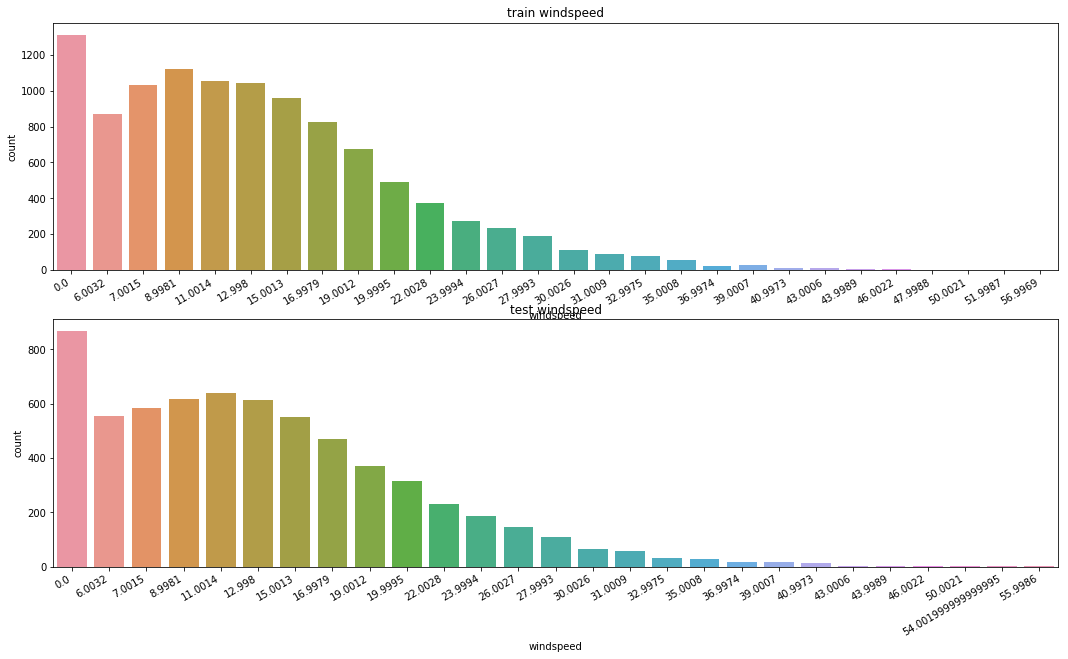

In [7]:
#'windspeed' has to be rearranged since it has the most 0 values.
# using machine learning tool
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30,ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed",ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [11]:
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0= train.loc[train['windspeed']!=0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [8]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):

    # classifying the windspeed data in 0 and other figures
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    # feature selection for windspeed prediction
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # Change the datatype of the windspeed data that is  not 0 to string type
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # load random forest classifier
    rfModel_wind = RandomForestClassifier()

    # With the selected features in 'wCol', train windspeed
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # Predict the windspeed with the trained values
    wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

    # For the evaluation, make new dataframe for the newly predicted values
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # Insert the predicted windspeed in 0 values
    predictWind0["windspeed"] = wind0Values

    # Merge the non-0 windspeed data and the predicted windspeed data
    data = predictWindNot0.append(predictWind0)

    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

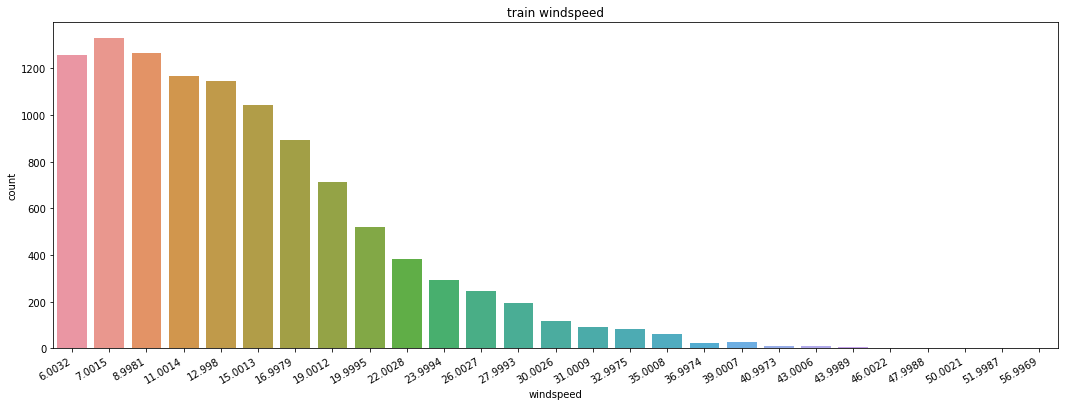

In [9]:
# Control the 0 values
train = predict_windspeed(train)


fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

### Feature Selection

In [12]:
categorical_feature_names = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [13]:
feature_names = ["season","weather","temp","atemp","humidity", "windspeed","year","hour","dayofweek","holiday","workingday"]

In [14]:
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [16]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [17]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [18]:
label_name = "count"
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

### RandomForest

In [20]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,n_jobs=-1, random_state=0)
#n_jobs=-1로 지정하면 컴퓨터의 모든 코어를 사용
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### Score
#### RMSLE(Root Mean Squared Logarithmic Error)
* 과대평가 된 항목보다는 과소평가 된 항목에 페널티를 준다.
* 오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root)으로 값이 작을수록 정밀도가 높다.
* 0에 가까운 값이 나올수록 정밀도가 높은 값이다.

$$ \sqrt{\frac{1}{n} \sum{i=1}n (\log(pi + 1) - \log(a_i+1))2 } $$

    ** \({n}\) is the number of hours in the test set
    ** \(p_i\) is your predicted count
    ** \(a_i\) is the actual count
    ** \(\log(x)\) is the natural logarithm
    
* 잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소평가 된 항목에 페널티를 주기 위해
* 정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미다.


In [35]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)

    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)

   
    difference = log_predict - log_actual
   
    difference = np.square(difference)

   
    mean_difference = difference.mean()

 
    score = np.sqrt(mean_difference)

    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [37]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

Wall time: 13.5 s
Score= 0.33062


### Train

In [38]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [39]:
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.59,   5.12,   4.48,   3.5 ,   3.09,   6.  ,  38.38, 105.96,
       236.57, 136.3 ])

[Text(0.5, 1.0, 'test')]

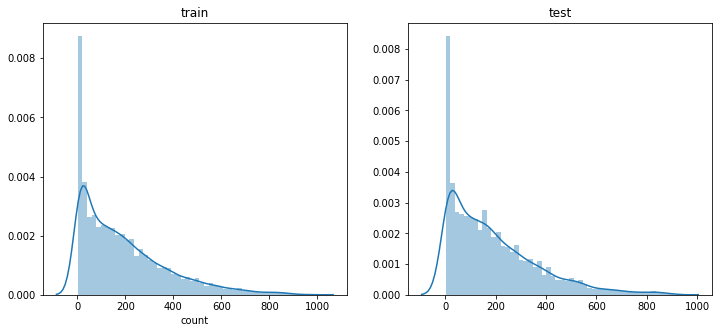

In [41]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train,ax=ax1, bins =50)
ax1.set(title="train")

sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")


### Submit

In [42]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.59
1,2011-01-20 01:00:00,5.12
2,2011-01-20 02:00:00,4.48
3,2011-01-20 03:00:00,3.50
4,2011-01-20 04:00:00,3.09


In [44]:
submission.to_csv("Score_{0:5f}_submission.csv".format(score), index=False)

In [45]:
430/3242

0.1326341764342998